In [1]:
import pandas as pd
import re,sys,os

import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import keras
import gensim

from time import time  # To time our operations
from collections import defaultdict  # For word frequency

# fix random seed for reproducibility
np.random.seed(7)
os.chdir("C:/Users/RathoreA/Downloads/zomato-bangalore-restaurants/")

C:\Users\RathoreA\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
revDF=pd.read_csv('zomato.csv')

In [3]:
revDF.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [68]:
cusinedata=[]
for e in revDF['dish_liked'].values:
    if pd.isna(e) != True:
        for t in e.split(','):
            cusinedata.append(t.lower().strip())
for e in revDF['cuisines'].values:
    if pd.isna(e) != True:
        for t in e.split(','):
            cusinedata.append(t.lower().strip())

In [69]:
cusinedata=list(set(cusinedata))

In [70]:
len(cusinedata)

2885

In [71]:
cusinedata[:3]

['hot chocolate fudge', 'burmese', 'aloo papdi chaat']

In [74]:
[f for f in cusinedata if 'chicken puff' in f]

['chicken puff']

In [51]:
revDF['dish_liked'].values[1]

'Momos, Lunch Buffet, Chocolate Nirvana, Thai Green Curry, Paneer Tikka, Dum Biryani, Chicken Biryani'

In [4]:
def cln(x):
    x=re.sub('\\n','',x)
    x= re.sub('[^0-9 a-z A-Z \s\.,\\/]','',x)
    x=x.strip()
    x=re.sub("x83x83x82x82x83x82x82x92",'',x)
    return(x)

revDF.reviews_list[0].split('RATED')[2].split('Rated')[0]
clRev=[]

for rev in revDF.reviews_list:
    rev1=''
    for each in rev.split('RATED'):
        rev1 = rev1 + ',' + cln(each)
    clRev.append(rev1)
    
revDF['cl_review']=clRev

def ratingExt(x):
    try:
        r=float(x.split("/")[0])/int(x.split("/")[1])
    except:
        r=np.nan
    return r
        
revDF['ratingPer']=revDF['rate'].apply(lambda x : ratingExt(x))

revDF2=revDF[['cl_review','ratingPer']]

def rating2number(x):
    if x >= .5:
        return 1
    else:
        return 0
    
revDF2.ratingPer2=revDF2.ratingPer.apply(lambda x : rating2number(x))

revDF2['text'] = revDF2['cl_review'].apply(lambda x: x.lower())
revDF2['text'] = revDF2['cl_review'].apply((lambda x: re.sub('[^a-zA-z0-9\s.]','',x)))



C:\Users\RathoreA\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
C:\Users\RathoreA\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\RathoreA\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

In [5]:
revDF2['text2']=revDF2.text.apply(lambda x : x.split('Rated'))

C:\Users\RathoreA\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [6]:
revDF3=revDF2.copy()

In [7]:
revDF3.head()

,cl_review,ratingPer,text,text2
0,",Rated 4.0,,n A beautiful place to dine in.Th...",0.82,Rated 4.0n A beautiful place to dine in.The i...,"[, 4.0n A beautiful place to dine in.The int..."
1,",Rated 4.0,,n Had been here for dinner with f...",0.82,Rated 4.0n Had been here for dinner with fami...,"[, 4.0n Had been here for dinner with family..."
2,",Rated 3.0,,n Ambience is not that good enoug...",0.76,Rated 3.0n Ambience is not that good enough a...,"[, 3.0n Ambience is not that good enough and..."
3,",Rated 4.0,,n Great food and proper Karnataka...",0.74,Rated 4.0n Great food and proper Karnataka st...,"[, 4.0n Great food and proper Karnataka styl..."
4,",Rated 4.0,,n Very good restaurant in neighbo...",0.76,Rated 4.0n Very good restaurant in neighbourh...,"[, 4.0n Very good restaurant in neighbourhoo..."


In [8]:
revDF3=revDF3[['ratingPer','text2']]

In [9]:
revDF3.head()

,ratingPer,text2
0,0.82,"[, 4.0n A beautiful place to dine in.The int..."
1,0.82,"[, 4.0n Had been here for dinner with family..."
2,0.76,"[, 3.0n Ambience is not that good enough and..."
3,0.74,"[, 4.0n Great food and proper Karnataka styl..."
4,0.76,"[, 4.0n Very good restaurant in neighbourhoo..."


In [10]:
lst_col = 'text2'

revDF3.columns.difference([lst_col])

Index(['ratingPer'], dtype='object')

In [11]:
lst_col = 'text2'
#revDF4=pd.DataFrame({col:np.repeat(revDF3[col].values, revDF3[lst_col].str.len())
#              for col in revDF3.columns.difference([lst_col])
#             }).assign(**{lst_col:np.concatenate(revDF3[lst_col].values)})[revDF3.columns.tolist()]

In [12]:
#revDF4=pd.DataFrame({'ratingPer':np.repeat(revDF3.ratingPer.values, revDF3.text2.str.len()),
#                        'text2':np.concatenate(revDF3.text2.values)})

In [13]:
#df = pd.DataFrame({
#    "a" : [1,2,3],
#    "b" : [[' ','asd','ase'],['awe','dfgg','sdasda'],['wewe']],
#    "c" : [5,6,7]
#})

#df
#df.set_index('a').b.apply(pd.Series).stack().reset_index(level=-1, drop=True).astype(str).reset_index()

In [14]:
revDF4=revDF3.set_index('ratingPer').text2.apply(pd.Series).stack().reset_index(level=-1, drop=True).astype(str).reset_index()


In [15]:
revDF4.columns=['ratingPer','text2']

In [16]:
revDF4.head()

,ratingPer,text2
0,0.82,
1,0.82,4.0n A beautiful place to dine in.The interi...
2,0.82,4.0n I was here for dinner with my family on...
3,0.82,2.0n Its a restaurant near to Banashankari B...
4,0.82,4.0n We went here on a weekend and one of us...


In [17]:
def func1(x):
    if len(x) == 0:
        return np.nan
    else:
        return x


revDF4['text3']=revDF4['text2'].apply(lambda x: func1(x))
revDF4=revDF4.dropna()
revDF4=revDF4.reset_index()
revDF4=revDF4.drop(['index','text3'],axis=1)

In [18]:
def textNumberSeparator(x):
    return re.split('\.[0-9]+n\s+',x)
    

In [19]:
revDF4['text3']=revDF4['text2'].apply(lambda x :textNumberSeparator(x))

In [20]:
revDF4['rating2']=revDF4['text3'].apply(lambda x : x[0])

In [21]:
revDF4.head()

,ratingPer,text2,text3,rating2
0,0.82,4.0n A beautiful place to dine in.The interi...,"[ 4, A beautiful place to dine in.The interior...",4
1,0.82,4.0n I was here for dinner with my family on...,"[ 4, I was here for dinner with my family on a...",4
2,0.82,2.0n Its a restaurant near to Banashankari B...,"[ 2, Its a restaurant near to Banashankari BDA...",2
3,0.82,4.0n We went here on a weekend and one of us...,"[ 4, We went here on a weekend and one of us h...",4
4,0.82,5.0n The best thing about the place is its a...,"[ 5, The best thing about the place is its amb...",5


In [22]:
def ratingExt(x):
    if len(x) > 1:
        return x[1]
    else:
        np.nan    

revDF4['text4']=revDF4['text3'].apply(lambda x : ratingExt(x))

In [23]:
#re.split('\.[0-9]+n\s+',revDF4['text2'][2])

In [24]:
revDF4.head(),revDF4.shape

(   ratingPer                                              text2  \
 0       0.82   4.0n  A beautiful place to dine in.The interi...   
 1       0.82   4.0n  I was here for dinner with my family on...   
 2       0.82   2.0n  Its a restaurant near to Banashankari B...   
 3       0.82   4.0n  We went here on a weekend and one of us...   
 4       0.82   5.0n  The best thing about the place is its a...   
 
                                                text3 rating2  \
 0  [ 4, A beautiful place to dine in.The interior...       4   
 1  [ 4, I was here for dinner with my family on a...       4   
 2  [ 2, Its a restaurant near to Banashankari BDA...       2   
 3  [ 4, We went here on a weekend and one of us h...       4   
 4  [ 5, The best thing about the place is its amb...       5   
 
                                                text4  
 0  A beautiful place to dine in.The interiors tak...  
 1  I was here for dinner with my family on a week...  
 2  Its a restaurant near to B

In [25]:
#revDF4[revDF4['text4']==np.nan]
null_columns=revDF4.columns[revDF4.isnull().any()]
revDF4.isnull().sum()
#print(revDF4[revDF4["text4"].isnull()][null_columns])


ratingPer       0
text2           0
text3           0
rating2         0
text4        2583
dtype: int64

In [26]:
revDF4.iloc[2598,]['text3']

[' 5 mainly for the location and service. .nThank you. ']

In [27]:
 #revDF4=revDF3.set_index('ratingPer').text2.apply(pd.Series).stack().reset_index(level=-1, drop=True).astype(int).reset_index()

In [28]:
revDF4=revDF4.dropna()

In [29]:
revDF4['rating2']=revDF4['rating2'].astype(int)

In [30]:
revDF4.head()

,ratingPer,text2,text3,rating2,text4
0,0.82,4.0n A beautiful place to dine in.The interi...,"[ 4, A beautiful place to dine in.The interior...",4,A beautiful place to dine in.The interiors tak...
1,0.82,4.0n I was here for dinner with my family on...,"[ 4, I was here for dinner with my family on a...",4,I was here for dinner with my family on a week...
2,0.82,2.0n Its a restaurant near to Banashankari B...,"[ 2, Its a restaurant near to Banashankari BDA...",2,Its a restaurant near to Banashankari BDA. Me ...
3,0.82,4.0n We went here on a weekend and one of us...,"[ 4, We went here on a weekend and one of us h...",4,We went here on a weekend and one of us had th...
4,0.82,5.0n The best thing about the place is its a...,"[ 5, The best thing about the place is its amb...",5,The best thing about the place is its ambiance...


In [31]:
revDF4.describe()

,ratingPer,rating2
count,1.306875e+06,1.306875e+06
mean,7.731172e-01,3.605508e+00
std,1.128684e-01,1.297528e+00
min,3.600000e-01,1.000000e+00
25%,7.200000e-01,3.000000e+00
50%,7.800000e-01,4.000000e+00
75%,8.600000e-01,5.000000e+00
max,9.800000e-01,5.000000e+00


In [32]:
def rater(x):
    if x > 3:
        return 1
    else:
        return 0
revDF4['ratingNew']=revDF4['rating2'].apply(lambda x : rater(x))

In [33]:
revDF4.head()

,ratingPer,text2,text3,rating2,text4,ratingNew
0,0.82,4.0n A beautiful place to dine in.The interi...,"[ 4, A beautiful place to dine in.The interior...",4,A beautiful place to dine in.The interiors tak...,1
1,0.82,4.0n I was here for dinner with my family on...,"[ 4, I was here for dinner with my family on a...",4,I was here for dinner with my family on a week...,1
2,0.82,2.0n Its a restaurant near to Banashankari B...,"[ 2, Its a restaurant near to Banashankari BDA...",2,Its a restaurant near to Banashankari BDA. Me ...,0
3,0.82,4.0n We went here on a weekend and one of us...,"[ 4, We went here on a weekend and one of us h...",4,We went here on a weekend and one of us had th...,1
4,0.82,5.0n The best thing about the place is its a...,"[ 5, The best thing about the place is its amb...",5,The best thing about the place is its ambiance...,1


In [35]:
#t2=list(set(cln(revDF['reviews_list'][13]).split('RATEDn')))[-1].split('Rated ')[0]

In [36]:
# traintest split
X_train, X_test, Y_train, Y_test = train_test_split(revDF4['text4'],revDF4.ratingNew, test_size = 0.05, random_state = 42)

In [37]:
X_test.head()

523480     kundana...... we went for a movie to vegacity ...
1135722    A person can never be too old for CupcakesnnHe...
266784     Good food and drink s view is the main USP it ...
879908     bad service  the thing which you order you get...
169157     Great place with wonderful ambience and helpfu...
Name: text4, dtype: object

In [171]:
#max_fatures = 2000
#tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer = Tokenizer(nb_words=100, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                   lower=True,split=' ')

#tokenizer.fit_on_texts(revDF4['text4'].values)

tokenizer.fit_on_texts(X_train.values)

#X = tokenizer.texts_to_sequences(revDF4['text4'].values)
X = tokenizer.texts_to_sequences(X_train.values)

X = pad_sequences(X, maxlen=100)



c:\users\rathorea\appdata\local\continuum\anaconda3\lib\site-packages\keras_preprocessing\text.py:178: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [256]:
X_train.values

array(['To be honest when no other place was delivering Shawarma plate to my address I had to forcefully order from here . I ordered without any expectations cos I havent heard much about this place. To my surprise the Shawarma plate was really good I havent tried any other items from here but Im planning to try a few soon ',
       'I got parcel Mutton puff  Chicken puff Black forest pastry and Pineapple pastry from here . All of them were fresh and flavourful. Pineapple pastry was yummy. ',
       'One of the few restaurants in Marathalli which serves Hookah I was really impressed with the ambiance as it has been set up with bean bags on one side of the restaurant and it also has a very big TV screen but was little irritating to us as it was so loud and after telling 3 to 4 times they reduced the volume.nnThe service section has to pick up pace as they were very slow in bringing the food we ordered for double apple cheesy macaroni chicken hotdog Crispy Paneer Burger Paneer Roll and c

In [242]:
from sklearn.model_selection import train_test_split
X_train2, X_valid, Y_train2, Y_valid = train_test_split(X,Y_train, test_size = 0.10, random_state = 42)

In [243]:
X_train2[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  1,  7, 49,  5,  6,  3,  5,  5, 69, 35, 52, 11,  1, 64,  5,
       70, 16,  2,  6, 19, 59, 26, 62, 77, 10, 10, 26, 10, 26, 10])

In [245]:
# create the model
embedding_vecor_length = 64
model = Sequential()
model.add(Embedding(100, embedding_vecor_length, input_length=X_train2.shape[1],dropout = 0.2))
model.add(LSTM(100,dropout_U = 0.2, dropout_W = 0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
model.fit(X_train2, Y_train2, validation_data=(X_valid, Y_valid), epochs=1, batch_size=64)

c:\users\rathorea\appdata\local\continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  after removing the cwd from sys.path.
c:\users\rathorea\appdata\local\continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(100, dropout=0.2, recurrent_dropout=0.2)`
  """


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 64)           6400      
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 72,501
Trainable params: 72,501
Non-trainable params: 0
_________________________________________________________________
None
Train on 1117377 samples, validate on 124154 samples
Epoch 1/1
1117377/1117377 [==============================] - 1759s 2ms/step - loss: 0.4123 - acc: 0.8107 - val_loss: 0.3673 - val_acc: 0.8352


In [172]:
t2="a nice place to eat"
X2 = tokenizer.texts_to_sequences([t2])
X2 = pad_sequences(X2, maxlen=100)


In [175]:
model=keras.models.load_model('modelsaved.h5')


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [176]:
model.predict(X2)

array([[0.79711956]], dtype=float32)

In [248]:
#model.save('modelsaved.h5')

In [257]:


Xtest = tokenizer.texts_to_sequences(X_test.values)
Xtest = pad_sequences(Xtest, maxlen=100)


In [259]:
Xtest.shape

(65344, 100)

In [266]:
pred_test=model.predict_classes(Xtest)

In [267]:
pred_test.shape

(65344, 1)

In [273]:
#pred_test[0]

In [274]:
#Y_test.values[0]

In [272]:
f1_score(Y_test.values, pred_test, average='macro') 

0.8195998631683123

In [276]:
target_names = ['class 0', 'class 1']
print(classification_report(Y_test.values, pred_test, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.82      0.71      0.76     23928
    class 1       0.85      0.91      0.88     41416

avg / total       0.84      0.84      0.83     65344



In [279]:
confusion_matrix(Y_test.values, pred_test)

array([[17054,  6874],
       [ 3740, 37676]], dtype=int64)

In [280]:
accuracy_score(Y_test.values, pred_test)

0.8375673359451518

In [34]:
import multiprocessing
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
cores

8

In [35]:
revDF4.text4[0]

'A beautiful place to dine in.The interiors take you back to the Mughal era. The lightings are just perfect.We went there on the occasion of Christmas and so they had only limited items available. But the taste and service was not compromised at all.The only complaint is that the breads could have been better.Would surely like to come here again. '

In [36]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [37]:
g=nlp(revDF4.text4[0])

In [38]:
def nounfilter(x):
    nt=[]
    nl=nlp(x)
    for n in nl:
        if n.pos_ in ['NOUN','PNOUN']:
            nt.append(n.text)
            
    return nt

In [39]:
' '.join(nounfilter(revDF4.text4[0]))

'place dine interiors era lightings occasion items taste service complaint breads'

In [43]:
#list of libraries used by the code
import string
from gensim.models import Word2Vec
import logging
from nltk.corpus import stopwords
import nltk
stop = stopwords.words('english')
#dataframe


In [46]:
w2v_model = Word2Vec(min_count=20,
                     window=4,
                     size=500,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1,sg=1)

c:\users\rathorea\appdata\local\continuum\anaconda3\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


In [48]:
df=revDF4.copy()

#df['patterns'] = df['text4'].apply(', '.join)
# print(df['patterns'])
#print(df['patterns'])
#cleaning the data using the NLP approach
df['patterns'] = df['text4'].apply(lambda x:' '.join(x.lower() for x in x.split()))
#df['patterns']= df['patterns'].apply(lambda x: ' '.join(x for x in x.split() if x not in string.punctuation))
df['patterns']= df['patterns'].str.replace('[^\w\s\.]','')
df['patterns']= df['patterns'].apply(lambda x: ' '.join(x for x in x.split() if  not x.isdigit()))
#df['patterns'] = df['patterns'].apply(lambda x:' '.join(x for x in x.split() if not x in stop))
#df['patterns'] = df['patterns'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))


In [49]:
df.head()

,ratingPer,text2,text3,rating2,text4,ratingNew,patterns
0,0.82,4.0n A beautiful place to dine in.The interi...,"[ 4, A beautiful place to dine in.The interior...",4,A beautiful place to dine in.The interiors tak...,1,a beautiful place to dine in.the interiors tak...
1,0.82,4.0n I was here for dinner with my family on...,"[ 4, I was here for dinner with my family on a...",4,I was here for dinner with my family on a week...,1,i was here for dinner with my family on a week...
2,0.82,2.0n Its a restaurant near to Banashankari B...,"[ 2, Its a restaurant near to Banashankari BDA...",2,Its a restaurant near to Banashankari BDA. Me ...,0,its a restaurant near to banashankari bda. me ...
3,0.82,4.0n We went here on a weekend and one of us...,"[ 4, We went here on a weekend and one of us h...",4,We went here on a weekend and one of us had th...,1,we went here on a weekend and one of us had th...
4,0.82,5.0n The best thing about the place is its a...,"[ 5, The best thing about the place is its amb...",5,The best thing about the place is its ambiance...,1,the best thing about the place is its ambiance...


In [50]:
" ".join(nltk.sent_tokenize(df['patterns'][0]))

'a beautiful place to dine in.the interiors take you back to the mughal era. the lightings are just perfect.we went there on the occasion of christmas and so they had only limited items available. but the taste and service was not compromised at all.the only complaint is that the breads could have been better.would surely like to come here again.'

In [51]:
re.sub('[^a-z 0-9]',' '," ".join(nltk.sent_tokenize(df['patterns'][0])))

'a beautiful place to dine in the interiors take you back to the mughal era  the lightings are just perfect we went there on the occasion of christmas and so they had only limited items available  but the taste and service was not compromised at all the only complaint is that the breads could have been better would surely like to come here again '

In [52]:
for f in nltk.sent_tokenize(df['patterns'][3]):
    f=re.sub('[^a-z 0-9]','',f)
    print(f.split())

['we', 'went', 'here', 'on', 'a', 'weekend', 'and', 'one', 'of', 'us', 'had', 'the', 'buffet', 'while', 'two', 'of', 'us', 'took', 'ala', 'carte']
['firstly', 'the', 'ambience', 'and', 'service', 'of', 'this', 'place', 'is', 'great', 'the', 'buffet', 'had', 'a', 'lot', 'of', 'items', 'and', 'the', 'good', 'was', 'good']
['we', 'had', 'a', 'pumpkin', 'halwa', 'intm', 'the', 'dessert', 'which', 'was', 'amazing']
['must', 'try', 'the', 'kulchas', 'are', 'great', 'here']
['cheers']


In [53]:
' '.join(nounfilter(revDF4.text4[0]))

'place dine interiors era lightings occasion items taste service complaint breads'

In [54]:
#taking the outer list
bigger_list=[]
for i in df['patterns'][:10000]:
    #li = list(i.split(" "))
    li=nltk.sent_tokenize(i)
    #bigger_list.append(li.split())
    for e in li:
        e=re.sub('[^a-z 0-9]',' ',e)
        e=' '.join(nounfilter(e))
        bigger_list.append(e.split())
#structure of data to be taken by the model.word2vec
#print("Data format for the overall list:",bigger_list)
#custom data is fed to machine for further processing
#print(model)

In [55]:
bigger_list[:3]

[['place', 'dine', 'interiors', 'mughal', 'era'],
 ['lightings', 'occasion', 'christmas', 'items'],
 ['taste', 'service', 'complaint', 'breads']]

In [56]:
t = time()

w2v_model.build_vocab(bigger_list, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.02 mins


In [57]:
len(bigger_list)

24380

In [58]:
bigger_list[:4]

[['place', 'dine', 'interiors', 'mughal', 'era'],
 ['lightings', 'occasion', 'christmas', 'items'],
 ['taste', 'service', 'complaint', 'breads'],
 ['dinner', 'family', 'weekday']]

In [59]:
t = time()

w2v_model.train(bigger_list, total_examples=w2v_model.corpus_count, epochs=50, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 10.82 mins


In [60]:
w2v_model.init_sims(replace=True)

In [61]:

w2v_model.wv.most_similar(positive=["place"],topn=20)[0][0]

'lot'

In [62]:
def topwords(w,n):
    wl=[]
    ml=w2v_model.wv.most_similar(positive=[w],topn=n)
    for i in range(n):
        wl.append(ml[i][0])
        
    return wl
    

In [63]:
attirbutes=['food','ambience','service']

In [64]:
df.text4[0]

'A beautiful place to dine in.The interiors take you back to the Mughal era. The lightings are just perfect.We went there on the occasion of Christmas and so they had only limited items available. But the taste and service was not compromised at all.The only complaint is that the breads could have been better.Would surely like to come here again. '

In [65]:
adict={}
comL=[]
for a in attirbutes:
    al1=topwords(a,100)
    al2=[]
    for w in df.text4[0].split():
        if w in al1:
            al2.append(w)
            
    adict[a]=al2
            
        
        
        
    

In [66]:
adict

{'food': ['place'],
 'ambience': ['place', 'dine', 'interiors', 'service'],
 'service': ['dine']}

In [71]:
topwords('interiors',50)

['view',
 'bda',
 'complex',
 'rooftop',
 'jaynagar',
 'arrangement',
 'peace',
 'gold',
 'hangout',
 'dining',
 'sizzler',
 'sunday',
 'chinese',
 'dint',
 'twist',
 'top',
 'jayanagar',
 'beer',
 'seating',
 'place',
 'team',
 'meister',
 'members',
 'lot',
 'feeling',
 'dhaba',
 'eye',
 'brew',
 'bsk',
 'banashankari',
 'expectations',
 'dine',
 'cafe',
 'nit',
 'decor',
 'beverages',
 'owners',
 'stage',
 'wedges',
 'ambiance',
 'cheers',
 'bengaluru',
 'let',
 'bar',
 'vegetable',
 'nmust',
 'list',
 'friends',
 'salsa',
 'thing']

### attribute based recommendation

In [73]:
revDF.dtypes

url                             object
address                         object
name                            object
online_order                    object
book_table                      object
rate                            object
votes                            int64
phone                           object
location                        object
rest_type                       object
dish_liked                      object
cuisines                        object
approx_cost(for two people)     object
reviews_list                    object
menu_item                       object
listed_in(type)                 object
listed_in(city)                 object
cl_review                       object
ratingPer                      float64
dtype: object

In [74]:
revDF.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city),cl_review,ratingPer
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari,",Rated 4.0,,n A beautiful place to dine in.Th...",0.82
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari,",Rated 4.0,,n Had been here for dinner with f...",0.82
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari,",Rated 3.0,,n Ambience is not that good enoug...",0.76
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari,",Rated 4.0,,n Great food and proper Karnataka...",0.74
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari,",Rated 4.0,,n Very good restaurant in neighbo...",0.76


In [75]:
attriuteCols=['online_order','book_table','rest_type','listed_in(type)','listed_in(city)']

In [76]:
revDF_att=pd.get_dummies(revDF[attriuteCols],drop_first=True)

In [98]:
revDF_att.head()

,online_order_Yes,book_table_Yes,"rest_type_Bakery, Beverage Shop","rest_type_Bakery, Cafe","rest_type_Bakery, Dessert Parlor","rest_type_Bakery, Food Court","rest_type_Bakery, Kiosk","rest_type_Bakery, Quick Bites","rest_type_Bakery, Sweet Shop",rest_type_Bar,...,listed_in(city)_Lavelle Road,listed_in(city)_MG Road,listed_in(city)_Malleshwaram,listed_in(city)_Marathahalli,listed_in(city)_New BEL Road,listed_in(city)_Old Airport Road,listed_in(city)_Rajajinagar,listed_in(city)_Residency Road,listed_in(city)_Sarjapur Road,listed_in(city)_Whitefield
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [99]:
revDF_att2=revDF[['name']].join(revDF_att)
revDF_att3=revDF_att2.head(20)

In [102]:
revDF_att3.head()

,name,online_order_Yes,book_table_Yes,"rest_type_Bakery, Beverage Shop","rest_type_Bakery, Cafe","rest_type_Bakery, Dessert Parlor","rest_type_Bakery, Food Court","rest_type_Bakery, Kiosk","rest_type_Bakery, Quick Bites","rest_type_Bakery, Sweet Shop",...,listed_in(city)_Lavelle Road,listed_in(city)_MG Road,listed_in(city)_Malleshwaram,listed_in(city)_Marathahalli,listed_in(city)_New BEL Road,listed_in(city)_Old Airport Road,listed_in(city)_Rajajinagar,listed_in(city)_Residency Road,listed_in(city)_Sarjapur Road,listed_in(city)_Whitefield
0,Jalsa,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Spice Elephant,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,San Churro Cafe,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Addhuri Udupi Bhojana,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Grand Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [101]:
revDF_att3.drop_duplicates(inplace=True)

c:\users\rathorea\appdata\local\continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [112]:
revDF_att4=revDF_att3.iloc[:9,:]

In [113]:
revDF_att4

,name,online_order_Yes,book_table_Yes,"rest_type_Bakery, Beverage Shop","rest_type_Bakery, Cafe","rest_type_Bakery, Dessert Parlor","rest_type_Bakery, Food Court","rest_type_Bakery, Kiosk","rest_type_Bakery, Quick Bites","rest_type_Bakery, Sweet Shop",...,listed_in(city)_Lavelle Road,listed_in(city)_MG Road,listed_in(city)_Malleshwaram,listed_in(city)_Marathahalli,listed_in(city)_New BEL Road,listed_in(city)_Old Airport Road,listed_in(city)_Rajajinagar,listed_in(city)_Residency Road,listed_in(city)_Sarjapur Road,listed_in(city)_Whitefield
0,Jalsa,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Spice Elephant,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,San Churro Cafe,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Addhuri Udupi Bhojana,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Grand Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Timepass Dinner,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Rosewood International Hotel - Bar & Restaurant,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Onesta,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Penthouse Cafe,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [114]:
revDF_att4.index=revDF_att4['name']


In [115]:
revDF_att4

,name,online_order_Yes,book_table_Yes,"rest_type_Bakery, Beverage Shop","rest_type_Bakery, Cafe","rest_type_Bakery, Dessert Parlor","rest_type_Bakery, Food Court","rest_type_Bakery, Kiosk","rest_type_Bakery, Quick Bites","rest_type_Bakery, Sweet Shop",...,listed_in(city)_Lavelle Road,listed_in(city)_MG Road,listed_in(city)_Malleshwaram,listed_in(city)_Marathahalli,listed_in(city)_New BEL Road,listed_in(city)_Old Airport Road,listed_in(city)_Rajajinagar,listed_in(city)_Residency Road,listed_in(city)_Sarjapur Road,listed_in(city)_Whitefield
name,,,,,,,,,,,,,,,,,,,,,
Jalsa,Jalsa,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Spice Elephant,Spice Elephant,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
San Churro Cafe,San Churro Cafe,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Addhuri Udupi Bhojana,Addhuri Udupi Bhojana,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Grand Village,Grand Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Timepass Dinner,Timepass Dinner,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Rosewood International Hotel - Bar & Restaurant,Rosewood International Hotel - Bar & Restaurant,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Onesta,Onesta,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Penthouse Cafe,Penthouse Cafe,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [116]:
revDF_att4=revDF_att4.drop('name',axis=1)

In [117]:
revDF_att4.loc['Onesta']

online_order_Yes                           1
book_table_Yes                             1
rest_type_Bakery, Beverage Shop            0
rest_type_Bakery, Cafe                     0
rest_type_Bakery, Dessert Parlor           0
rest_type_Bakery, Food Court               0
rest_type_Bakery, Kiosk                    0
rest_type_Bakery, Quick Bites              0
rest_type_Bakery, Sweet Shop               0
rest_type_Bar                              0
rest_type_Bar, Cafe                        0
rest_type_Bar, Casual Dining               0
rest_type_Bar, Lounge                      0
rest_type_Bar, Pub                         0
rest_type_Bar, Quick Bites                 0
rest_type_Beverage Shop                    0
rest_type_Beverage Shop, Cafe              0
rest_type_Beverage Shop, Dessert Parlor    0
rest_type_Beverage Shop, Quick Bites       0
rest_type_Bhojanalya                       0
rest_type_Cafe                             0
rest_type_Cafe, Bakery                     0
rest_type_

In [118]:
namesL=revDF_att4.index
namesL=list(namesL.values)

In [119]:
dt={}
for n in namesL:
    for m in namesL:
        if n != m:
            v1=revDF_att4.loc[n].values
            v2=revDF_att4.loc[m].values
            
            sim=0
            for i in range(len(v1)):
                if v1[i]==v2[i] and v1[i] != 0:
                    sim += 1
                    
            if sim > 0:
                tuple = (n, m)
                dt[tuple]=sim
    


In [120]:
edges=dt
import networkx as nx
from itertools import combinations


In [121]:
B = nx.DiGraph()
nodecolor=[]
for ed, weight in edges.items():
    #print(ed)
    if ed[0]!='Vertical2' and ed[0]!='Vertical3' and  ed[1]!='Vertical2' and ed[1]!='Vertical3':
        B.add_edge(ed[0], ed[1], weight=weight)


In [122]:
revDF_att4.index

Index(['Jalsa', 'Spice Elephant', 'San Churro Cafe', 'Addhuri Udupi Bhojana',
       'Grand Village', 'Timepass Dinner',
       'Rosewood International Hotel - Bar & Restaurant', 'Onesta',
       'Penthouse Cafe'],
      dtype='object', name='name')

In [283]:
for k in B.nodes:
    if (k == "Jalsa"):
        nodecolor.append('blue')
    elif (k == "Spice Elephant"):
        nodecolor.append('Magenta')
    elif (k == "San Churro Cafe"):
        nodecolor.append('crimson')
    elif (k == "Addhuri Udupi Bhojana"):
        nodecolor.append('maroon')
    elif (k == "Grand Village"):
        nodecolor.append('red')
    elif (k == "Onesta"):
        nodecolor.append('lawngreen')
    elif (k == "Penthouse Cafe"):
        nodecolor.append('deeppink')
    elif (k == "Cafe Shuffle"):
        nodecolor.append('royalblue')
    elif (k == "Caf-Eleven"):
        nodecolor.append('navy')
   
    ###########################################
        
   

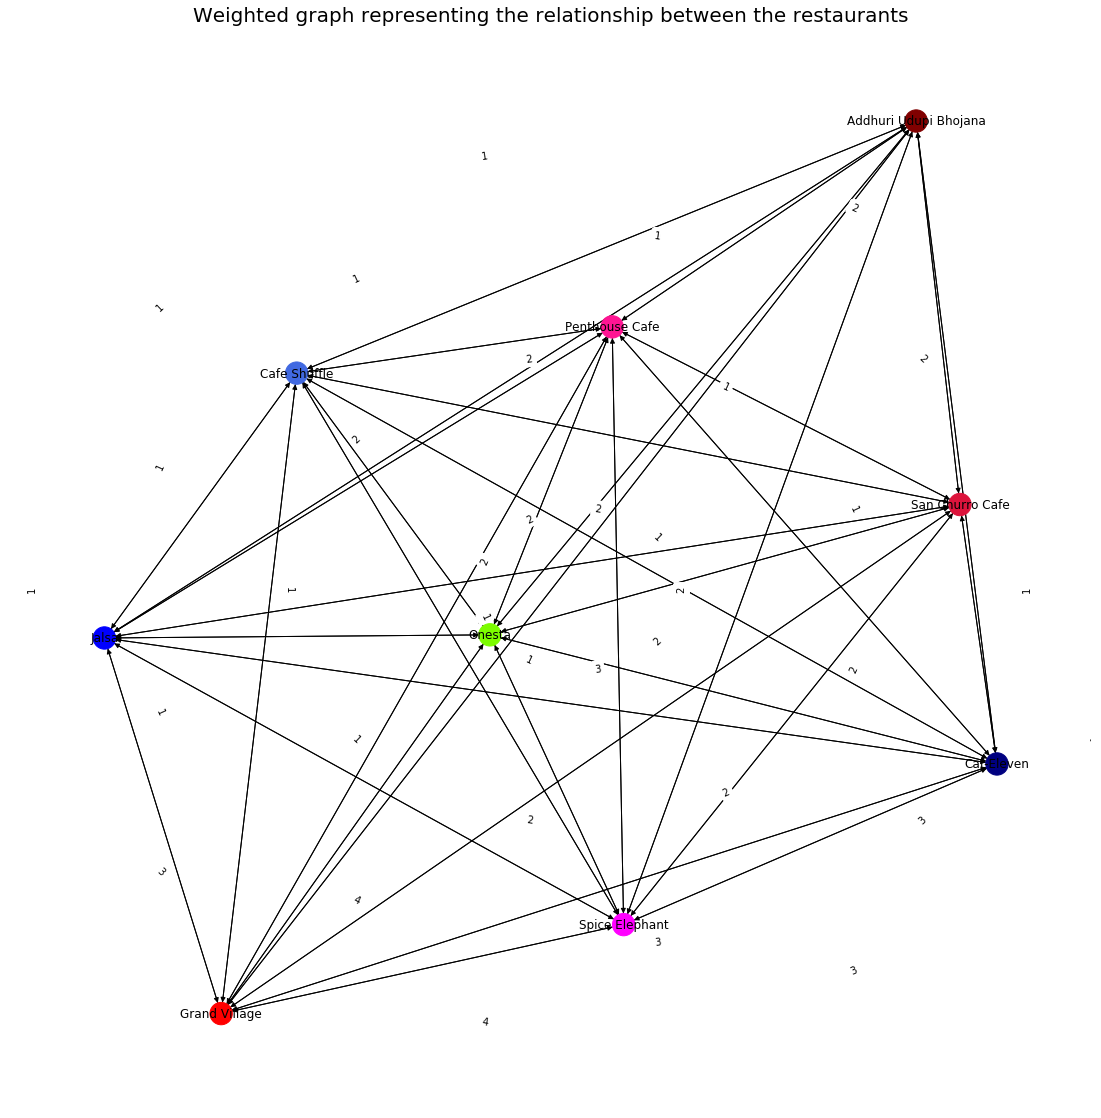

In [294]:
plt.figure(figsize = (15,15))
#nx.draw(B, pos=nx.circular_layout(B), node_size=500, with_labels=True, node_color=nodecolor)
nx.draw(B, node_size=500, with_labels=True, node_color=nodecolor)

nx.draw_networkx_edge_labels(B, pos=nx.circular_layout(B), edge_labels=nx.get_edge_attributes(B, 'weight'))

plt.title('Weighted graph representing the relationship between the restaurants', size=20)
plt.show()

In [123]:
data_matrix=revDF_att3.iloc[:,1:].values

In [124]:
n_rest=len(revDF_att3)
n_att=len(revDF_att3.iloc[:,1:].columns)

In [125]:
n_att

129

In [126]:
from sklearn.metrics.pairwise import pairwise_distances 

user_similarity = pairwise_distances(data_matrix, metric='cosine')
item_similarity = pairwise_distances(data_matrix.T, metric='cosine')

In [127]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #We use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [128]:
data_matrix[2]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=uint8)

In [129]:
mean_user_rating=data_matrix.mean(axis=1)

In [130]:
ratings_diff = (data_matrix - mean_user_rating[:, np.newaxis])


In [131]:
ratings_diff.shape

(20, 129)

In [132]:
data_matrix[0].shape

(129,)

In [133]:
user_prediction=predict(data_matrix,user_similarity,type='user')

In [134]:
item_prediction = predict(data_matrix, item_similarity, type='item')


In [136]:
item_prediction.shape

(20, 129)

In [138]:
pd.DataFrame(item_prediction)

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
0,0.010238,0.014434,0.031250,0.031250,0.031250,0.031250,0.031250,0.031250,0.031250,0.031250,...,0.031250,0.031250,0.031250,0.031250,0.031250,0.031250,0.031250,0.031250,0.031250,0.031250
1,0.006343,0.014434,0.023438,0.023438,0.023438,0.023438,0.023438,0.023438,0.023438,0.023438,...,0.023438,0.023438,0.023438,0.023438,0.023438,0.023438,0.023438,0.023438,0.023438,0.023438
2,0.006192,0.016214,0.023438,0.023438,0.023438,0.023438,0.023438,0.023438,0.023438,0.023438,...,0.023438,0.023438,0.023438,0.023438,0.023438,0.023438,0.023438,0.023438,0.023438,0.023438
3,0.009133,0.012363,0.015625,0.015625,0.015625,0.015625,0.015625,0.015625,0.015625,0.015625,...,0.015625,0.015625,0.015625,0.015625,0.015625,0.015625,0.015625,0.015625,0.015625,0.015625
4,0.006343,0.010583,0.015625,0.015625,0.015625,0.015625,0.015625,0.015625,0.015625,0.015625,...,0.015625,0.015625,0.015625,0.015625,0.015625,0.015625,0.015625,0.015625,0.015625,0.015625
5,0.006343,0.014434,0.023438,0.023438,0.023438,0.023438,0.023438,0.023438,0.023438,0.023438,...,0.023438,0.023438,0.023438,0.023438,0.023438,0.023438,0.023438,0.023438,0.023438,0.023438
6,0.006343,0.010583,0.015625,0.015625,0.015625,0.015625,0.015625,0.015625,0.015625,0.015625,...,0.015625,0.015625,0.015625,0.015625,0.015625,0.015625,0.015625,0.015625,0.015625,0.015625
7,0.012658,0.016883,0.039062,0.039062,0.039062,0.039062,0.039062,0.039062,0.039062,0.039062,...,0.039062,0.039062,0.039062,0.039062,0.039062,0.039062,0.039062,0.039062,0.039062,0.039062
8,0.005200,0.018463,0.031250,0.031250,0.031250,0.031250,0.031250,0.031250,0.031250,0.031250,...,0.031250,0.031250,0.031250,0.031250,0.031250,0.031250,0.031250,0.031250,0.031250,0.031250
9,0.005200,0.018463,0.031250,0.031250,0.031250,0.031250,0.031250,0.031250,0.031250,0.031250,...,0.031250,0.031250,0.031250,0.031250,0.031250,0.031250,0.031250,0.031250,0.031250,0.031250


In [144]:
e1=pd.DataFrame(user_prediction)

In [141]:
e=np.dot(data_matrix,data_matrix.T)

In [142]:
e.shape

(20, 20)

In [169]:
e

array([[4, 3, 2, 1, 2, 3, 2, 3, 2, 2, 2, 3, 3, 1, 2, 2, 2, 2, 1, 2],
       [3, 3, 2, 1, 2, 3, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2],
       [2, 2, 3, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 3, 2, 2, 2, 1, 2],
       [1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [3, 3, 2, 1, 2, 3, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2],
       [2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [3, 2, 2, 1, 1, 2, 1, 5, 3, 3, 3, 4, 4, 2, 3, 3, 3, 3, 2, 3],
       [2, 2, 2, 1, 1, 2, 1, 3, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 3, 4],
       [2, 2, 2, 1, 1, 2, 1, 3, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 3, 4],
       [2, 2, 2, 1, 1, 2, 1, 3, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 3, 4],
       [3, 2, 2, 1, 1, 2, 1, 4, 4, 4, 4, 5, 5, 3, 3, 4, 4, 4, 3, 4],
       [3, 2, 2, 1, 1, 2, 1, 4, 4, 4, 4, 5, 5, 3, 3, 4, 4, 4, 3, 4],
       [1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3],
       [2, 2, 3, 1, 1, 2, 1, 3, 3,

In [168]:
np.argmax(e[3])

3

In [164]:
e[10]

array([2, 2, 2, 1, 1, 2, 1, 3, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 3, 4],
      dtype=uint8)

In [145]:
e2=np.dot(e1,e1.T)

In [147]:
pd.DataFrame(e2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,2.574275,2.605607,2.415688,2.526569,2.679919,2.605607,2.679919,2.255822,1.757076,1.757076,1.757076,1.917008,1.917008,2.006572,2.222196,1.757076,1.757076,1.757076,2.006572,1.757076
1,2.605607,2.657349,2.452817,2.576648,2.744083,2.657349,2.744083,2.251149,1.743066,1.743066,1.743066,1.892583,1.892583,2.015511,2.236408,1.743066,1.743066,1.743066,2.015511,1.743066
2,2.415688,2.452817,2.323706,2.422810,2.528293,2.452817,2.528293,2.165554,1.773123,1.773123,1.773123,1.884300,1.884300,1.993406,2.166339,1.773123,1.773123,1.773123,1.993406,1.773123
3,2.526569,2.576648,2.422810,2.573209,2.687719,2.576648,2.687719,2.241955,1.832078,1.832078,1.832078,1.941709,1.941709,2.105048,2.241342,1.832078,1.832078,1.832078,2.105048,1.832078
4,2.679919,2.744083,2.528293,2.687719,2.858959,2.744083,2.858959,2.302945,1.788713,1.788713,1.788713,1.931707,1.931707,2.100522,2.294858,1.788713,1.788713,1.788713,2.100522,1.788713
5,2.605607,2.657349,2.452817,2.576648,2.744083,2.657349,2.744083,2.251149,1.743066,1.743066,1.743066,1.892583,1.892583,2.015511,2.236408,1.743066,1.743066,1.743066,2.015511,1.743066
6,2.679919,2.744083,2.528293,2.687719,2.858959,2.744083,2.858959,2.302945,1.788713,1.788713,1.788713,1.931707,1.931707,2.100522,2.294858,1.788713,1.788713,1.788713,2.100522,1.788713
7,2.255822,2.251149,2.165554,2.241955,2.302945,2.251149,2.302945,2.114653,1.806361,1.806361,1.806361,1.914396,1.914396,1.964814,2.079434,1.806361,1.806361,1.806361,1.964814,1.806361
8,1.757076,1.743066,1.773123,1.832078,1.788713,1.743066,1.788713,1.806361,1.800140,1.800140,1.800140,1.798393,1.798393,1.864386,1.804385,1.800140,1.800140,1.800140,1.864386,1.800140
9,1.757076,1.743066,1.773123,1.832078,1.788713,1.743066,1.788713,1.806361,1.800140,1.800140,1.800140,1.798393,1.798393,1.864386,1.804385,1.800140,1.800140,1.800140,1.864386,1.800140
